In [1]:
import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage
import os

In [4]:
def read_dataset(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),0)
        
        if img is not None:
            img = cv2.resize(img,(64,64))
            images.append(img)
    return images

In [5]:
images = read_dataset('data/all-mias/')
images.extend(read_dataset('data/dental'))
images.extend(read_dataset('data/RawImage/TrainingData'))
len(images)

722

In [6]:
len(images[0])

64

In [7]:
images = np.array(images)
print images.shape

(722, 64, 64)


In [8]:
images = images.astype('float32')/255.
images = np.reshape(images, (images.shape[0],64,64,1))

In [9]:
images.shape

(722, 64, 64, 1)

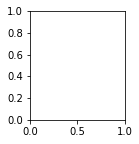

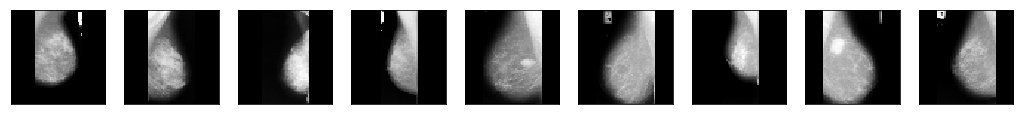

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(images[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
#adding noise
def salt_and_pepper(image,factor):
    noise_factor = factor
    
    x_train_noisy = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [13]:
def gaussian_noise(x_train,mean,sigma,proportion):    
    x_train_noisy = []
    for i in range(x_train.shape[0]):
        image = x_train[i]
        noise = proportion*np.random.normal(mean,sigma,x_train[0].shape)
        x_train_noisy.append(image + noise)
     
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy

In [14]:
def poisson_noise(x_train):
    
    x_train_noisy = skimage.util.random_noise(x_train, mode='poisson', seed=None, clip=True)    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_test_noisy

In [15]:
def gamma_noise(x_train,shape,scale=1.0):
    
    row,col,ch = x_train[0].shape
    
    x_train_noisy = x_train + np.random.gamma(shape,scale,x_train.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    return x_train_noisy

In [314]:
x_test.shape

(72, 64, 64, 1)

In [106]:
x_train_noisy,x_test_noisy = salt_and_pepper(x_train,x_test,0.5)

In [165]:
x_train_noisy,x_test_noisy = gaussian_noise(x_train,x_test,0,1,0.1)

In [189]:
x_train_noisy = gamma_noise(images,1,1)

In [90]:
x_train_noisy,x_test_noisy = poisson_noise(x_train,x_test)

In [61]:
def add_noise(images):
    #x_train = np.reshape(x_train, (len(x_train), 64*64))  # adapt this if using `channels_first` image data format
    #x_test = np.reshape(x_test, (len(x_test), 64*64))  # adapt this if using `channels_first` image data format
    batch = images.shape[0]/4;
    noise1 = gaussian_noise(images[0:batch],0,1,0.1)
    noise2 = gaussian_noise(images[batch:2*batch],0,1,0.5)
    noise3 = gaussian_noise(images[2*batch:3*batch],0,2,0.2)
    noise4 = gaussian_noise(images[3*batch:],0,3,0.1)
    
    noisy_set = []
    for data in [noise1,noise2,noise3,noise4]:
        for image in data:
            noisy_set.append(image)
    
    return np.array(noisy_set)
    
    
    

In [36]:
from random import shuffle
shuffle(images)

In [37]:
noisy_set = add_noise(images)

In [38]:
noisy_set = np.array(noisy_set)
print noisy_set.shape

(722, 64, 64, 1)


In [39]:
train_size = int(images.shape[0]*0.8)
x_train = images[0:train_size]
x_train_noisy = noisy_set[0:train_size]
x_test = images[train_size:]
x_test_noisy = noisy_set[train_size:]
print x_train_noisy.shape
print x_test_noisy.shape

(577, 64, 64, 1)
(145, 64, 64, 1)


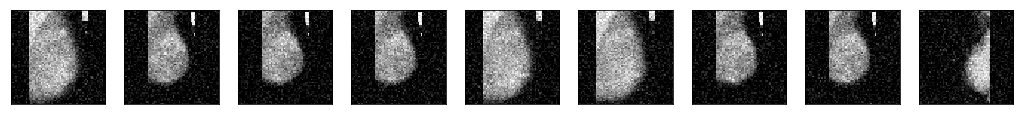

In [74]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [41]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard


Using TensorFlow backend.


In [42]:
input_img = Input(shape=x_train_noisy[0].shape)  # adapt this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

print autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0         
__________

In [43]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=True)])

Train on 577 samples, validate on 145 samples
Epoch 1/50
577/577 [==============================] - 27s - loss: 0.3895 - val_loss: 0.3085
Epoch 2/50
577/577 [==============================] - 26s - loss: 0.2827 - val_loss: 0.2825
Epoch 3/50
577/577 [==============================] - 25s - loss: 0.2786 - val_loss: 0.2776
Epoch 4/50
577/577 [==============================] - 26s - loss: 0.2696 - val_loss: 0.2753
Epoch 5/50
577/577 [==============================] - 30s - loss: 0.2688 - val_loss: 0.2753
Epoch 6/50
577/577 [==============================] - 29s - loss: 0.2655 - val_loss: 0.2712
Epoch 7/50
577/577 [==============================] - 28s - loss: 0.2653 - val_loss: 0.2693
Epoch 8/50
577/577 [==============================] - 30s - loss: 0.2644 - val_loss: 0.2750
Epoch 9/50
577/577 [==============================] - 24s - loss: 0.2628 - val_loss: 0.2771
Epoch 10/50
577/577 [==============================] - 25s - loss: 0.2628 - val_loss: 0.2704
Epoch 11/50
577/577 [============

In [62]:
test_images = read_dataset('data/Test')
test_images = np.array(test_images)
test_images = test_images.astype('float32')/255.
test_images = np.reshape(test_images, (test_images.shape[0],64,64,1))
noisy_test_images = add_noise(test_images)
print noisy_test_images.shape

(120, 64, 64, 1)


In [117]:
out = autoencoder.predict(noisy_test_images,verbose=1)

120/120 [==============================] - 1s     


In [188]:
def display_images(images,n):
    plt.figure(figsize=(20, 2))
    for i in range(1,n):
        ax = plt.subplot(1, n, i)
        plt.imshow(images[i].reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

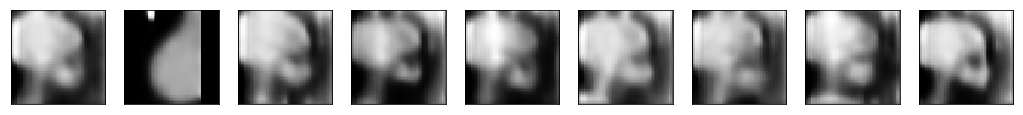

In [189]:
display_images(out,10)

In [65]:
import math
def mse(x, y):
    return np.linalg.norm(x - y)

def get_mse(imageA,imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [66]:
def get_psnr(imageA,imageB):
    maxI = 1
    try:
        return 20*math.log10(maxI) - 10*math.log10(get_mse(imageA,imageB))
    except:
        return 20*math.log10(maxI)

In [131]:
def get_psnr_result(x_test, out):
    psnr_sum = 0
    for i in range(out.shape[0]):
        psnr_sum += get_psnr(x_test[i],out[i])
    return 1.0*psnr_sum/out.shape[0];

In [130]:
get_psnr_result(out,test_images)

(120, 64, 64, 1)


17.11545793522805

In [122]:
get_psnr_result(x_test_noisy,x_test)

12.71897797159574

In [377]:
def bm3d_denoising(x_test_noisy):
    denoised=[]
    for image in x_test_noisy:
        img = image.reshape(64,64)
        dno = np.array(img)
        print img
        
        denoised.append(dno)
    return denoised

In [347]:
image = cv2.imread('data/two',0)

In [379]:
image = np.resize(image,(64,64))
denoised=np.array(image)
print image
cv2.fastNlMeansDenoising(image,denoised)
cv2.imshow('tt',image)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [76]:
import bm3d

In [184]:
def bm3d_denoise(noisy_image):
    noisy_image = noisy_image.reshape(noisy_image.shape[0],64,64)
    noisy_image = noisy_image*255
    denoised = []
    for i in range(noisy_image.shape[0]):
        Basic_img = bm3d.BM3D_1st_step(noisy_image[i])
        Final_img = bm3d.BM3D_2nd_step(Basic_img, noisy_image[i])
        denoised.append(Final_img)
        print "Image " + str(i) + "denoised"
    return denoised

In [186]:
print noisy_test_images.shape
bm3d_out = bm3d_denoise(noisy_test_images[0:11])

(120, 64, 64, 1)
Image 0denoised
Image 1denoised
Image 2denoised
Image 3denoised
Image 4denoised
Image 5denoised
Image 6denoised
Image 7denoised
Image 8denoised
Image 9denoised
Image 10denoised


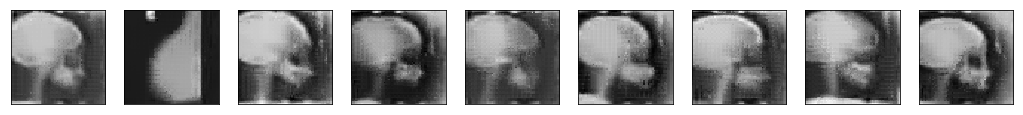

In [190]:
display_images(bm3d_out,10)

In [196]:
get_psnr_result(bm3d_out,out[0:10])

0.0

In [176]:
get_psnr(img,pred)

-32.986967755027734

In [177]:
img.max()

255

In [170]:
pred = out[0].reshape(64,64)*255
pred = pred.astype('uint8')

In [179]:
pred

array([[ 22,  16,  20, ..., 216, 189, 124],
       [ 11,  13,  16, ..., 230, 202, 114],
       [ 11,  16,  22, ..., 229, 194,  96],
       ..., 
       [ 60, 175, 213, ..., 160, 139,  87],
       [ 64, 155, 189, ..., 145, 131,  92],
       [ 80, 118, 141, ..., 115, 107,  91]], dtype=uint8)

In [175]:
Final_img

matrix([[265, 149,  74, ..., 246, 245, 244],
        [209,  94,  21, ..., 241, 241, 240],
        [167,  51, -20, ..., 232, 234, 234],
        ..., 
        [228, 219, 225, ..., 169, 179, 185],
        [233, 230, 231, ..., 184, 198, 206],
        [242, 240, 238, ..., 185, 202, 210]])